The idea of this project is to walk you through the way I tackled a problem that I found interesting and worth exploring: can you solve a Rubik's cube using Simulated Annealing. The most popular ways of solving the cube are either by applying a set of rules, depending on the configuration of the cube at each stage of the solving process, or using graph search algorithms, like A*, or Kociemba’s algorithm. But I wanted to know if you can use a Genetic Algorithm, like Simulated Annealing, to solve the problem, not by simply brute-forcing all combinations and finding the fastest way to the solution. So here I'm attempting exactly this.


---------

Before we start, it's good to first define the notations that we'll be sticking to. In order to represent the 3D cube, we'll use a 2D folded representation, with each side being numerated 1-6:

white = 1 | blue = 2 | red = 3 | green = 4 | orange = 5 | yellow = 6

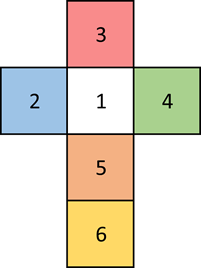

The numerical color representations are used only for the presentation of the cube state. For the cube manipulations, the colors follow the same order, but start from 0 (white=0, blue=1, red=2, etc.) in order to comply with matrix indexing, which starts from 0. This makes coding the logic simpler.

---------

Each side is being distinguished by its middle piece/tile, which does not move. All other tiles on the face can change color based on the rotations, but not the middle ones. This is done for simplicity of following the cube rearrangements. This means that for the possible cube movements we ignore whole cube rotations, and focus on the rotations of faces alone. Rotations of middle rows are ignored as well because 1. they would result in the middle tiles moving, and 2. the same movement can be ahieved with two rotations of the neighbouring rows, so it's better to keep it simple. 

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

GROUND_TRUTH is a 6x3x3 matrix representing the solved cube, where each color is encoded with a number 1-6.


In [ ]:
GROUND_TRUTH = np.array([mat*(idx+1) for idx,mat in enumerate(np.ones((6,3,3)))])

The first thing is to make sure that we create a working representation of the cube, so that the rotations/moves that we apply will properly adjust the tiles on the cube. To do so, one can go about different ways, such as hard-coding each move, but here a look-up table (`ROTATION_LOOKUP_TABLE`) is used to succinctly encompass all the necessary movements that we want to do. Because we've already decided that only the outer rows on each side can move, then the possible moves are only 12, which are the rotations of each side (including the clockwise (CW) and counter-clockwise (CCW) rotations). In Rubik terms: *U, U', D, D', R, R', L, L', F, F', B, B'* are the moves we'll be using. 

Explaining the look-up table further: Each row corresponds to how different rows/cols from different faces get
mapped when a particular face is rotated. The three numbers in each subarray
encode which row/col on which face will go where. The first number shows the
number of the row/col, starting from 0. The second number shows if it's row
or col, with row = 0, col = 1. The third number is the face/color. The order of the subarrays on the particular row maps where the particular row/col will go after the rotation, ei if we look at row 3 (rotation of face 4): 
[0,0,2] -> [0,0,3] -> [0,0,4] -> [0,0,1] -> [0,0,2]

**Example**: 
For row 1 of the `ROTATION_LOOKUP_TABLE`, for the first transformation we have that `[0,0,2]` goes to `[0,0,3]`, which means that the first row (`[0,0,..]`) of the red face (`[..,..,2]`) will go in the place of the first row (`[0,0,..]`) of the green face (`[..,..,3]`).
And after `[0,0,3]` will go to `[0,0,4]`, which will go to `[0,0,1]`, etc.
```
[0,0,..] == first row 
[0,1,..] == first col
[1,0,..] == second row
[1,1,..] == second col
...
```
That way the table encodes all the information we need to make
the particular move. With a total of 12 moves (including the CCW, where the
order of the subarrays on the rows is just reversed), we have all needed
moves to place a tile anywere on the cube. 

In [ ]:
ROTATION_LOOKUP_TABLE = np.array([
    [[0,0,2], [0,0,3], [0,0,4], [0,0,1], [0,0,2]],      # rotate face 1
    [[0,1,0], [0,1,4], [0,1,5], [2,1,2], [0,1,0]],      # rotate face 2
    [[0,0,0], [0,1,1], [2,0,5], [2,1,3], [0,0,0]],      # rotate face 3              
    [[2,1,0], [0,1,2], [2,1,5], [2,1,4], [2,1,0]],      # rotate face 4
    [[2,0,0], [0,1,3], [0,0,5], [2,1,1], [2,0,0]],      # rotate face 5              
    [[2,0,4], [2,0,3], [2,0,2], [2,0,1], [2,0,4]] ])    # rotate face 6

A simple function is also used, which translates the face matrix either CW, or CCW. 

In [ ]:
def rotate_face(face_matrix, direction):
    """Looking at the cube face, rotate/flip the face matrix representation
    either CW(direction = 1) or CCW(direction = -1)
    """
    reflection_matrix = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]])
    if direction == 1:
        return np.matmul(face_matrix.transpose(), reflection_matrix)
    elif direction == -1:
        return np.matmul(face_matrix, reflection_matrix).transpose()

We also need a function that flips the order of the tiles in a row/col. Because we're using a flattened 2D representation of the 3D cube, some rotations will result in, say a row from one face being mapped into a col on another, but in reverse. You can take the CW rotation of the blue face(face 2) and see that the left col from the yellow face(face 6) will replace the right col of the red face(face 3). But because of the nature of the rotation, the tiles will be upside-down after the rotation (sitting on the red face) from how they were before the rotation (when they were on the yellow face). So we need the `flip_XOR` function to account for that. 

The way I've encoded the rotations in the `ROTATION_LOOKUP_TABLE` means that we can figure out if a flip is needed by comparing the first two parameters of the row/col before and after the transformation. The color of the tiles doesn't play a role. If either of the two parameters is the same before and after the transformation, then a flip is needed. So a transformation from [0,1,..] -> [0,0,..] needs a flip because the first coordinate is 0 for both, but the second is different. If both, or neither of the two parameters are the same, then no flip is needed, say for [0,1,..] -> [2,0,..]. Overall this acts as a XOR gate, if we raise -1 to the power of the number of differing parameter. The output of -1 means flip, and 1 means keep the same. 

In [ ]:
def flip_XOR(i_0, j_0, i_1, j_1):
    diffs = [i_0 - i_1, j_0 - j_1] 
    # flip only if one of the row/col params differs => XOR gate =>
    # (-1)^1=-1 otherwise (-1)^2=1 or (-1)^0=1
    return (-1)**np.count_nonzero(diffs)

As the `ROTATION_LOOKUP_TABLE` shows the row/col mapping/replacement for a CW 
rotation, the `[::direction]`, present for the `transfomations_table` definition, would be `[::1]` when the rotation direction is CW, so nothing will change. But when the rotation is CCW, the rows/cols need to be mapped in the reverse order. So `[::direction]` will be `[::-1]`, which flips the order of the subarrays.

Example: if we again look at the rotation of face 1 (row 1 of the `ROTATION_LOOKUP_TABLE`), if the rotation is CCW, the `transfomations_table` will look like:

`[[0,0,2], [0,0,1], [0,0,4], [0,0,3], [0,0,2]]`

instead of 

`[[0,0,2], [0,0,3], [0,0,4], [0,0,1], [0,0,2]]`

In [ ]:
def move(face_matrix_num, direction, current_cube_state):  
    """Transform the cube under a signle face rotation"""
    new_cube_state = current_cube_state.copy()
    face_matrix = current_cube_state[face_matrix_num]
    # update just the rotated face
    new_cube_state[face_matrix_num] = rotate_face(face_matrix, direction)
    
    # get the rotation row for the particular face    
    transfomations_table = ROTATION_LOOKUP_TABLE[face_matrix_num,:,:][::direction]
    # update the affected sides around the rotated face, based on the transfomations_table
    for t in range(len(transfomations_table)-1):
        i_0 = transfomations_table[t][0]
        j_0 = transfomations_table[t][1]
        k_0 = transfomations_table[t][2]
        
        i_1 = transfomations_table[t+1][0]
        j_1 = transfomations_table[t+1][1]
        k_1 = transfomations_table[t+1][2]
        
        flip_sign = flip_XOR(i_0, j_0, i_1, j_1) # -1 or 1
        # make sure that row/col is in an array form (flatten part)
        new_cubelets = (current_cube_state[k_0].take((i_0,), axis=j_0)).flatten()
        # check if new tile position is row or col, and flip the row/col accordingly
        if j_1 == 0:
            new_cube_state[k_1][i_1,:] = new_cubelets[::flip_sign]
        elif j_1 == 1:
            new_cube_state[k_1][:,i_1] = new_cubelets[::flip_sign]
       
    return new_cube_state

In order to choose the moves that the Simulated Annealing algorithm will take, we need to have a way of deciding which moves are good and which are not. So we need to measure the "fitness" of the cube at each state. So we can do it by calculating the difference between the current cube state and the solved cube (`GROUND_TRUTH`) => how many tiles are not in position = fitness of cube. In the worst case scenario, 48 tiles will not be in position (because the 6 center tiles will always be in position, and a cube has a total of 54 tiles). 

In [ ]:
def calculate_fitness(cube_state):
    return np.count_nonzero(GROUND_TRUTH - cube_state)

Now that we have all the functions that we need in order to simulate a move and also caclulate its fitness, we can actually get to the actual coding of how we choose the next step, where the Simulated Annealing algorithm finally comes into play. 

The `choose_move` function is nothing more than a while loop that exits when an acceptable move is found. The way you find an acceptable move is as follows:


1. Generate a random move by randomly choosing a face to rotate (between 0-5) and a direction to rotate this face to (CW or CCW)
2. Calculate the fitness of the cube before and after the move
3. Find the "delta"/difference in the cube fitness
4. If the Δ is negative -> go with this move because the move increases the orderness of the cube. 
5. If the Δ is positive -> choose the move with probability $P = \mathrm{e}^{-Δ/T}$, where T is the temperature of the current run of the algorithm (explained more later). As Δ is positive (because for negative Δ, we enter point 4.), P is limited between (0,1).  So this gives us the opportunity to take a "wrong move", or one which increases the disorderness of the cube, with a particular probability. The bigger the P, the larger the chance we have of choosing that move.

The functions runs until it randomly finds a move, which decreases the Δ, or it probabilistically chooses a move that increases the Δ. There also an `if statement`, which checks if the loop has ran more than 100 times without choosing a move, and if so, reverts to the previous move. This is included because it sometimes happens that all the moves that can be taken result in positive Δ and P is very small (ex: 5x10^(-4)), so practically no move can be chosen in a reasonable number of tries. The algorithm has fallen into a local minima and cannot escape. This usually happens with small values of T, after the algorithm has gone through many iterations. A way to deal with this is to revert the move, and the parameters, to a previous move with the hope it will choose an escape move this time. 



In [ ]:
def choose_move(current_cube_state, current_cube_fitness, T, previous_move):
    no_move = True
    count_iters = 0
    while no_move:
        # add counter if while loop gets stuck at local minima
        if count_iters == 100:
            prev_cube_state = move(previous_move[0], -previous_move[1], current_cube_state)
            prev_move_reversed = [previous_move[0], -previous_move[1]]
            return prev_move_reversed, -100, prev_cube_state
        count_iters += 1 
        
        # randomly choose new move and assess it's fitness
        new_move = random.randint(0,5)
        new_move_direction = random.choice([-1, 1])   
        new_cube_state = move(new_move, new_move_direction, current_cube_state)
        delta = calculate_fitness(new_cube_state) - current_cube_fitness
        
        if delta <= 0:
            break
        P = np.exp(-delta/T) # returns probabilty for a move between (0,1)
        random_prob = np.random.uniform(0,1) # generate random (0,1) probability
        # if random probability is smaller -> take move
        if P > random_prob:
            break
            
    chosen_move = [new_move, new_move_direction] 
    return chosen_move, delta, new_cube_state

Now that we can choose a move, the next step is to actually make the algorithm choose the set of moves that will end up with a solved cube. This is called the "cooling process" in the Simulated Annealing algorithm. The algorithm starts with a temperature T, and after each move, this temperature decreases by a fixed cooling rate, analogous to annealing in metallurgy (but in metallurgy the cooling rate is usually not fixed). 

The temperature T affects the probability of choosing a move, as we saw earlier. But if we dissect the equation $P = \mathrm{e}^{-Δ/T}$ a bit further, we can see that for very large T (T>>Δ) the probability P approahes 1, so the probability of choosing any move, even if it's the worst move, is almost 100%. So then the Simulated Annealing algorithm is more like a Random Walk algorithm. If T<<Δ (here << and >> can be as little as x10 difference), then P will approach 0, making the algorithm closer to a Gradient Descent algorithm, where only the best move, or in our case one which decreases Δ, will be chosen. 

So for the cooling process, it's common to start with a high T, when the algorithm can make "wrong" moves at the beginning, and thus jump over local minima, and as the temperature decreases with each move, the algorithm will make more calculated moves to reach the global minima. Of course, there is a real chance of the algorithm getting stuck at a local minima still, so I have implemented the move counter, which I talked about before. 

So the `cooling_process` function takes in the mixed cube, which needs to be solved, the initial temperature, the cooling rate of the temperature, and the maximum number of steps (the number of steps is good to be set because it might happen that the cooling process gets stuck trying to ever-more refine the final solution). The function then tries to find the most suitable move, given the cube state after the previous move, and the new temperature after the cooling. This continues until the max number of moves is reached, or if a solution is found. The function outputs a history of the moves taken by the algorithm in an array form, where each row contains information about that move as follows:
```
[<rotated face>, <rotation direction>, <move Δ>, <new cube fitness>, <T for move>]
```



In [ ]:
def cooling_process(current_cube_state, T, temp_decrease_factor, max_iterations):
    # initiate with random nums so choose_move function works
    moves_history = [[0, 1, 0, 0, 0]] 
    
    cube_developemnt = list()
    cube_developemnt.append(current_cube_state)
    for iterate in range(max_iterations):
        
        current_cube_fitness = calculate_fitness(current_cube_state)
        if current_cube_fitness == 0:
            solved_cube = current_cube_state.copy()
            print("Solved!")
            return moves_history, solved_cube
        chosen_move, delta, current_cube_state = choose_move(current_cube_state, 
                                                             current_cube_fitness, 
                                                             T,
                                                             moves_history[-1][:2])
        cube_developemnt.append(current_cube_state)
        new_cube_fitness = calculate_fitness(current_cube_state)

        moves_history.append([chosen_move[0], chosen_move[1], delta, new_cube_fitness, T])
        T = T*temp_decrease_factor
    
    partially_solved_cube = current_cube_state.copy()
    print("Partially solved!")
    return moves_history, partially_solved_cube

A final function, which randomly mixes up a cube, is necessary. It taken in a parameter, specifying the number of mixing moves to be performed. The output is the mixed cube, but also a history of the mixing moves, so they can be traced back, for reference and back-tracing. 

In [ ]:
def mix_cube(num_mixing_moves):
    mix_history = []
    current_cube_state = GROUND_TRUTH.copy()
    for move_idx in range(num_mixing_moves):
        rand_move = random.randint(0,5)
        rand_dir = random.choice([-1, 1])
        current_cube_state = move(rand_move, rand_dir, current_cube_state)
        mix_history.append((rand_move,rand_dir))
        
    return mix_history, current_cube_state   

These are all the functions that are needed for the Rubik's cube solver to work. The `cooling_process` function really is the one that combines all previous functions into one, so it's simple to write and run a script that actually mixes up randomly a cube and then solves it, where the output `moves_history` of the cooling process will give the ordered moves that need to be performed to reach the solved cube state. 

In [ ]:
mix_history, mixed_cube = mix_cube(num_mixing_moves=1)
T = 1
temp_decrease_factor = 0.99
max_iterations = 1000

moves_history1, cube1 = cooling_process(mixed_cube, T, temp_decrease_factor, max_iterations)

print(calculate_fitness(mixed_cube))
print(calculate_fitness(cube1))
moves_history_array = np.array(moves_history1)[1:]
plt.plot(np.insert(moves_history_array[:,3],0,calculate_fitness(mixed_cube)))

Or one can write a simple script to run the algorithm on 100 different cubes, mixed up with the same number of cubes, and find how many times the algorithm found a solution

In [ ]:
T = 0.2
temp_decrease_factor = 0.99
max_iterations = 500
num_mixing_moves = 2

results = list()
for ii in range(100): 
    mix_history, mixed_cube = mix_cube(num_mixing_moves)
    moves_history1, cube1 = cooling_process(mixed_cube, T, temp_decrease_factor, max_iterations)

    results.append([calculate_fitness(mixed_cube), calculate_fitness(cube1)])

results = np.array(results)
len(results[results==0])

But testing this with large number of mixing moves shows a problem, as the algorithm is not able to achieve a full solution. It solves a few moves and many times increases the orderness of the cube, but gets stuck and cannot continue, as the temperature gets too low and the algorithm is not able to really take "wrong" moves, so it cannot escape its local minima. Giving it a boost by increasing the temperature, or rewinding a few moves doesn't seem to fix the problem, it still gets stuck on the same move, or maybe 1-2 moves further. For smaller number of mixing moves it seems to still find solutions, yet not always. For 1 mixing move it always finds the solution, for 2 moves - around 60-70% of the time, and it decreases down as we increase the moves. The largest number of moves observed that it is able to find a solution after 100 runs is 8, which is not little, but it still is not perfect. And this is usually because the mixing just turns out to be simpler, resembling more a 5 or 6 moves mixed cube. The number of moves that the algorithm takes in order to find the solution varies a lot, from 1 to more than 200, depending on the number of mixing moves.  


--------

My conclusion for this project is that Simulated Annealing is able to solve some Rubik's cubes, if they are a bit simpler, but is not a reliable way of finding the solution to the problem. It also takes a very large number of moves to reach a solution, more than if more conventional algorithms are used. So overall it's a fun way of approaching the problem, but better and faster methods exist, and it doesn't seem to improve on any aspect, other than maybe the complexity of coding the solution. 